In [1]:
import copy
import gymnasium as gym
import numpy as np
from datetime import datetime, timedelta

In [2]:
class Config():
    def __init__(self):
        self.env_name = "CartPole-v1"
        self.total_episode = 5000
        self.gamma = 0.99
        self.num_action = 2
        self.n_bins = 10
        self.epsilon=1.0
        self.decay_step=int(0.1 * self.total_episode)
        self.eps_min=0.05
        self.test_frequency = 10

config = Config()

In [3]:
import numpy as np

class Discretizer:
    def __init__(self, n_bins=6):
        self.n_bins = n_bins
        self.cart_pos_bins = np.linspace(-4.8, 4.8, n_bins - 1)
        self.cart_vel_bins = np.linspace(-3.0, 3.0, n_bins - 1)  
        self.pole_angle_bins = np.linspace(-0.419, 0.419, n_bins - 1)
        self.pole_vel_bins = np.linspace(-3.0, 3.0, n_bins - 1) 

    def discretize(self, state):
        cart_pos, cart_vel, pole_angle, pole_vel = state

        d_cart_pos = np.digitize(cart_pos, self.cart_pos_bins)
        d_cart_vel = np.digitize(cart_vel, self.cart_vel_bins)
        d_pole_angle = np.digitize(pole_angle, self.pole_angle_bins)
        d_pole_vel = np.digitize(pole_vel, self.pole_vel_bins)

        return (d_cart_pos, d_cart_vel, d_pole_angle, d_pole_vel)

    def get_state_index(self, discrete_state):
        d = discrete_state
        return ((d[0] * self.n_bins + d[1]) * self.n_bins + d[2]) * self.n_bins + d[3]

In [4]:
def select_action(Q_Table, state, epsilon):
    if np.random.rand() < epsilon or state not in Q_Table:
        return np.random.randint(config.num_action)
    else:
        return np.argmax(Q_Table[state])

In [5]:
def decay_epsilon(epsilon, decay_per_step):
    epsilon = max(epsilon - decay_per_step, config.eps_min)
    return epsilon

In [6]:
def test(config, Q_Table, discretizer):
    env = gym.make(config.env_name)
    state, _ = env.reset()
    state = discretizer.get_state_index(discretizer.discretize(state))
    done = False
    episode_reward = 0.

    while not done:
        if state not in Q_Table:
            action = np.random.randint(config.num_action)
        else:
            action = np.argmax(Q_Table[state])
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = discretizer.get_state_index(discretizer.discretize(next_state))
        episode_reward += reward
        done = terminated or truncated
        state = next_state
    return episode_reward

In [7]:
def add(config, returns, Q_table, state, action = None, episode_return = 0):
    if action is None:
        for a in range(config.num_action):
            if (state, a) not in returns.keys():
                returns[(state, a)] = [episode_return]
                if state not in Q_table.keys():
                    Q_table[state] = np.zeros((config.num_action,))
                Q_table[state][a] = episode_return
            else:
                returns[(state, a)].append(episode_return)
                Q_table[state][a] = np.mean(returns[(state, a)])
    else:
        if (state, action) not in returns.keys():
            returns[(state, action)] = [episode_return]
            if state not in Q_table.keys():
                Q_table[state] = np.zeros((config.num_action,))
            Q_table[state][action] = episode_return
        else:
            returns[(state, action)].append(episode_return)
            Q_table[state][action] = np.mean(returns[(state, action)])        

In [ ]:
discretizer = Discretizer(config.n_bins)
Q_Table = dict()
returns = dict()
episode_rewards = []
test_episode_rewards = []
epsilon = config.epsilon
decay_per_step = (epsilon - config.eps_min) / config.decay_step
max_test_reward = 0.

for episode in range(1, config.total_episode+1):
    env = gym.make(config.env_name)
    state, _ = env.reset()
    state = discretizer.get_state_index(discretizer.discretize(state))
    done = False

    episode_reward = 0.
    rewards = []
    states = []
    actions = []

    while not done:
        action = select_action(Q_Table, state, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = discretizer.get_state_index(discretizer.discretize(next_state))
        episode_reward += reward
        rewards.append(reward)
        states.append(state)
        actions.append(action)
        done = terminated or truncated
        state = next_state
    episode_rewards.append(episode_reward)
    epsilon = decay_epsilon(epsilon, decay_per_step)

    add(config, returns, Q_Table, state, None, 0)
    episode_return = 0
    for state, action, reward in zip(states[::-1], actions[::-1], rewards[::-1]):
        episode_return = episode_return * config.gamma + reward
        add(config, returns, Q_Table, state, action, episode_return)
    
    if episode % 10 == 0:
        print(f"Episode: {episode} Rewards: {episode_reward} Mean_Rewards: {np.array(episode_rewards[-min(100, len(episode_rewards)):]).mean():.4f} Epsilon: {epsilon:.4f}")

    if episode % config.test_frequency == 0:
        test_episode_reward = test(config, Q_Table, discretizer)
        test_episode_rewards.append(test_episode_reward)
        max_test_reward = max(max_test_reward, test_episode_reward)
        if len(test_episode_rewards) % 10 == 0:
            print(f"Test Episode {len(test_episode_rewards)}: Rewards: {test_episode_reward} \
Mean_Rewards: {np.array(test_episode_rewards[-min(100, len(test_episode_rewards)):]).mean():.4f} Max_Rewards: {max_test_reward}")

Episode: 1000 Rewards: 163.0 Mean_Rewards: 271.8900 Epsilon: 0.0500
Episode: 2000 Rewards: 143.0 Mean_Rewards: 309.2400 Epsilon: 0.0500
Episode: 3000 Rewards: 178.0 Mean_Rewards: 297.5700 Epsilon: 0.0500
Episode: 4000 Rewards: 500.0 Mean_Rewards: 446.0700 Epsilon: 0.0500
Episode: 5000 Rewards: 500.0 Mean_Rewards: 443.4800 Epsilon: 0.0500


In [13]:
(np.array(episode_rewards) == 500).sum()/len(episode_rewards), (np.array(test_episode_rewards) == 500).sum()/len(test_episode_rewards)

(0.1898, 0.244)

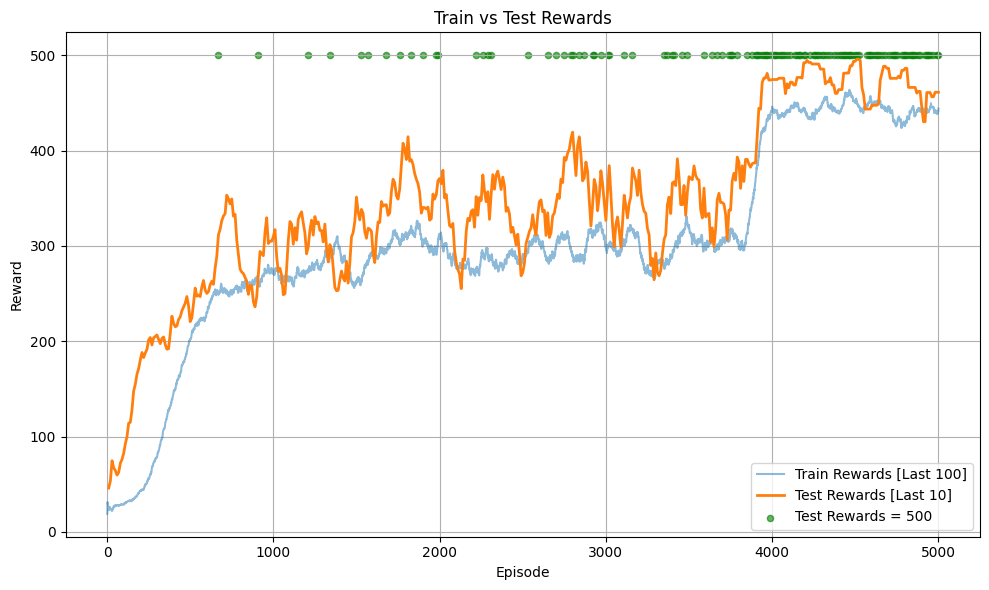

In [20]:
import matplotlib.pyplot as plt

train_episodes = list(range(1, len(episode_rewards)+1))
test_episodes = list(range(10, len(episode_rewards)+1, 10))  # test sau mỗi 10 train episodes (0-based index)

episode_rewards = np.array(episode_rewards)
test_episode_rewards = np.array(test_episode_rewards)

mean_rewards = []
mean_test_rewards = []
for i in range(len(episode_rewards)):
    mean_rewards.append(episode_rewards[max(0, i-100):i+1].mean())
for i in range(len(test_episode_rewards)):
    mean_test_rewards.append(test_episode_rewards[max(0, i-10):i+1].mean())

plt.figure(figsize=(10, 6))

idx_full_rewards = np.array(test_episode_rewards) == 500

plt.plot(train_episodes, mean_rewards, label='Train Rewards [Last 100]', alpha=0.5)
plt.plot(test_episodes, mean_test_rewards, label='Test Rewards [Last 10]', linewidth=2)
plt.scatter(np.array(test_episodes)[idx_full_rewards], 
            np.array(test_episode_rewards)[idx_full_rewards], label='Test Rewards = 500', alpha=0.6, s=20, color = 'green')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Train vs Test Rewards")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

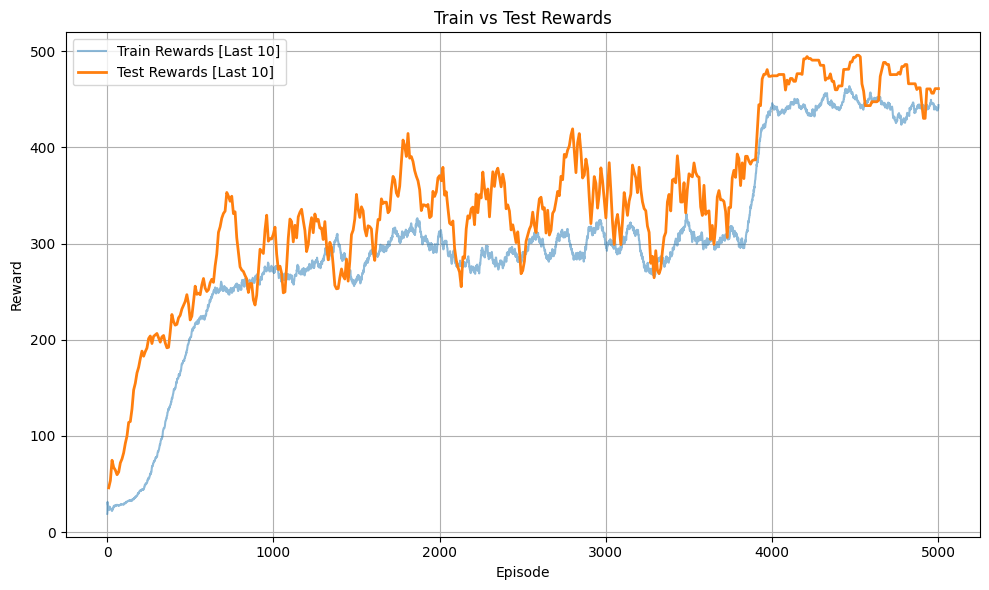

In [21]:
plt.figure(figsize=(10, 6))

plt.plot(train_episodes, mean_rewards, label='Train Rewards [Last 10]', alpha=0.5)
plt.plot(test_episodes, mean_test_rewards, label='Test Rewards [Last 10]', linewidth=2)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Train vs Test Rewards")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()